# MNIST Combiner

Combines two models, an SKLearn model and a Tensorflow model for MNIST. The combination does a simple average of the two models.

In [1]:
!pygmentize MnistCombiner.py

import logging
logger = logging.getLogger(__name__)

class MnistCombiner(object):
    def __init__(self, metrics_ok=True):
        print("MNIST Combiner Init called")

    def aggregate(self, Xs, features_names):
        print("MNIST Combiner aggregate called")
        logger.info(Xs)
        return (Xs[0]+Xs[1])/2.0


## Start Minikube

In [ ]:
!minikube start --memory 4096 --feature-gates=CustomResourceValidation=true --extra-config=apiserver.Authorization.Mode=RBAC

In [ ]:
!kubectl create clusterrolebinding kube-system-cluster-admin --clusterrole=cluster-admin --serviceaccount=kube-system:default

In [ ]:
!kubectl config set-context $(kubectl config current-context) --namespace=seldon

## Build Combiner image

In [3]:
!eval $(minikube docker-env) && s2i build -E environment_rest . seldonio/seldon-core-s2i-python36:0.4-SNAPSHOT seldonio/mnistcombiner_rest:0.1

---> Installing application source...
Build completed successfully


## Install Helm

In [ ]:
!kubectl -n kube-system create sa tiller
!kubectl create clusterrolebinding tiller --clusterrole cluster-admin --serviceaccount=kube-system:tiller
!helm init --service-account tiller

In [ ]:
!kubectl rollout status deploy/tiller-deploy -n kube-system

## Install Seldon Core

In [ ]:
!kubectl create namespace seldon

In [ ]:
!helm install ../../../helm-charts/seldon-core-crd --name seldon-core-crd

In [ ]:
!helm install ../../../helm-charts/seldon-core --name seldon-core --namespace seldon \
    --set ambassador.enabled=true

In [ ]:
!kubectl rollout status deploy/seldon-core-seldon-cluster-manager
!kubectl rollout status deploy/seldon-core-seldon-apiserver
!kubectl rollout status deploy/seldon-core-ambassador

To send requests to Ambassador ingress in another terminal run:
    
```
kubectl port-forward $(kubectl get pods -n seldon -l service=ambassador -o jsonpath='{.items[0].metadata.name}') -n seldon 8002:8080
```

In [1]:
%matplotlib inline
import utils
from visualizer import get_graph
mnist = utils.download_mnist()

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [ ]:
get_graph("mnist_combiner.json")

In [ ]:
!pygmentize mnist_combiner.json

In [4]:
!kubectl apply -f mnist_combiner.json

seldondeployment.machinelearning.seldon.io/mnistcombo created


In [5]:
!kubectl rollout status deploy/mnistcombo-mnistcombo-3715bc4

deployment "mnistcombo-mnistcombo-3715bc4" successfully rolled out


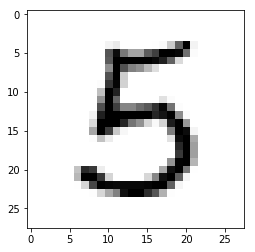

{'meta': {'puid': 'h4tuqh36rdmu3bcdlcpc0r3mke', 'tags': {}, 'routing': {'combiner': -1}, 'requestPath': {'tfmodel': 'seldonio/deep-mnist:0.1', 'skmodel': 'seldonio/sk-mnist:0.1', 'combiner': 'seldonio/mnistcombiner_rest:0.1'}, 'metrics': []}, 'data': {'names': ['class:0', 'class:1', 'class:2', 'class:3', 'class:4', 'class:5', 'class:6', 'class:7', 'class:8', 'class:9'], 'ndarray': [[0.01777702378264318, 2.8567853860295145e-06, 0.017218996949183444, 0.0812305503214399, 0.0010864619398489594, 0.8603562653064728, 0.00041601501288823783, 2.683608215647837e-07, 0.02169143408536911, 0.00022013898706063628]]}}


In [7]:
utils.predict_rest_mnist(mnist,"mnistcombo")